In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold

from sparse_vector.sparse_vector import SparseVector

# Data loading

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]

feature_names = [i[:-4] for i in os.listdir('./data_hg_38/features/sparse/stem_cells') if i.endswith('.pkl')]

In [4]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'./data_hg_38/dna/') if f"{chrom}_" in i])
    return ''.join([load(f"./data_hg_38/dna/{file}") for file in files])

In [5]:
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
ZDNA = load('./data_hg_38/targets/sparse/zdna.pkl')

DNA_features = {feature: load(f'./data_hg_38/features/sparse/stem_cells/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/322 [00:00<?, ?it/s]

# Dataset class

In [6]:
from torch.utils import data

class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, max_omics_value = 1000):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        self.max_omics_value = max_omics_value

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            if chrom in source:
                if self.max_omics_value == 1:
                    feature_matr.append(np.ones(end-begin, dtype=np.float32))
                else:
                    feature_matr.append(source[chrom][begin:end])
            else:
                feature_matr.append(np.zeros(end-begin, dtype=np.float32))
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/self.max_omics_value)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        y = self.labels_source[interval[0]][interval[1]: interval[2]]

        return (X, y)

# Data selection

In [7]:
width = 100

def get_train_test_data(max_omics_value=1000):
    np.random.seed(10)
    
    ints_in = []
    ints_out = []

    for chrm in chrom_names:
        for st in trange(0, ZDNA[chrm].shape - width, width):
            interval = [st, min(st + width, ZDNA[chrm].shape)]
            if ZDNA[chrm][interval[0]: interval[1]].any():
                ints_in.append([chrm, interval[0], interval[1]])
            else:
                ints_out.append([chrm, interval[0], interval[1]])

    ints_in = np.array(ints_in)
    ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]
    
    np.random.seed(42)
    equalized = np.vstack((ints_in, ints_out))
    equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]
    
    train_inds, test_inds = next(StratifiedKFold().split(equalized, [elem[0] for elem in equalized]))
    train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]
    
    np.random.seed(42)
    params = {'batch_size': 32,
              'num_workers':16,
              'shuffle':True}
    
    train_dataset = Dataset(chrom_names, feature_names, 
                           DNA, DNA_features, 
                           ZDNA, train_intervals,
                           max_omics_value = max_omics_value)
    
    test_dataset = Dataset(chrom_names, feature_names, 
                           DNA, DNA_features, 
                           ZDNA, test_intervals,
                           max_omics_value = max_omics_value)
    
    loader_train = data.DataLoader(train_dataset, **params)
    loader_test = data.DataLoader(test_dataset, **params)
    
    return loader_train, loader_test

# Train and test

In [8]:
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from IPython.display import clear_output
import time
from copy import deepcopy

In [9]:
def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(torch.transpose(output, 2, 1), y_batch)



def train_epoch(model, optimizer):
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.train()
    for X_batch, y_batch in loader_train:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
        optimizer.zero_grad()
        output = model(X_batch)
        if output.dim() == 2:  
            output = output.unsqueeze(0)  
        pred = torch.argmax(output, dim=2)
        with torch.no_grad():
            y_pred = nn.Softmax(dim=1)(output)[:, :,1].cpu().numpy().flatten()
            if np.std(y_batch.cpu().numpy().flatten()) == 0:
                roc_auc = 0
                precision = 0
                recall = 0
            else:
                roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                        y_pred)

                precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten(), zero_division=0)
                recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())
                
            precision_log.append(precision)
            recall_log.append(recall)             
            f1_log.append(f1_score(y_batch.cpu().numpy().flatten(),
                             pred.cpu().numpy().flatten(), zero_division=0))

        roc_auc_log.append(roc_auc)
        acc = torch.mean((pred.to(device) == y_batch).float())
        acc_log.append(acc.cpu().numpy())
        loss = loss_func(output, y_batch)
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        loss_log.append(loss)
        torch.cuda.empty_cache()
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def test(model):
    np.random.seed(42)
    roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log = [], [], [], [], [], []
    model.eval()
    if isinstance(model, torch.nn.DataParallel):
        model = model.module
    means = []
    with torch.no_grad():
        for X_batch, y_batch in loader_test:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            output = model(X_batch)

            if output.dim() == 2:  
                output = output.unsqueeze(0)  
            means.append(y_batch.sum().cpu() / (1.0 * y_batch.shape[0]))
            pred = torch.argmax(output, dim=2)
            if np.std(y_batch.cpu().numpy().flatten()) == 0:
                roc_auc = 0
                precision = 0
                recall = 0
            else:
                roc_auc = roc_auc_score(y_batch.cpu().numpy().flatten(),
                                        nn.Softmax(dim=1)(output)[:, :,1].detach().cpu().numpy().flatten())
                precision = precision_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten(), zero_division=0)
                recall = recall_score(y_batch.cpu().numpy().flatten(), pred.cpu().numpy().flatten())

            f1 = f1_score(y_batch.cpu().numpy().flatten(),
                                      pred.cpu().numpy().flatten(), zero_division=0)
            if f1 == 0.0 and torch.all(y_batch == 0) and torch.all(pred == 0):
                pass
            else:
                f1_log.append(f1)
            roc_auc_log.append(roc_auc)
            precision_log.append(precision)
            recall_log.append(recall)     
            acc = torch.mean((pred.to(device) == y_batch).float())
            acc_log.append(acc.cpu().numpy())
            loss = loss_func(output, y_batch)
            loss_log.append(loss.item())
            torch.cuda.empty_cache()
    return roc_auc_log, precision_log, recall_log, f1_log, acc_log, loss_log

def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
              np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_auc_log, train_pr_log, train_rec_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], [], [], []
    val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], [], [], []
    times = []
    best_models = []
    for epoch in range(n_epochs):
        start_time = time.time()
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_auc, train_pr, train_rec, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_pr, val_rec, val_f1, val_acc, val_loss = test(model)
        
        best_models.append(deepcopy(model))
        
        end_time = time.time()
        times.append(end_time - start_time)
        BatchSize = len(train_loss)
        
        train_auc_log.extend(train_auc)
        train_pr_log.extend(train_pr)
        train_rec_log.extend(train_rec)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)

        val_auc_log.append(np.mean(val_auc))
        val_pr_log.append(np.mean(val_pr))
        val_rec_log.append(np.mean(val_rec))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))
        
        clear_output()
        plot_history(train_loss_log,     val_loss_log,     'Loss',     BatchSize)    
        plot_history(train_acc_log, val_acc_log, 'Accuracy', BatchSize)
        plot_history(train_auc_log, val_auc_log, 'Auc',      BatchSize)
        plot_history(train_f1_log, val_f1_log,   'F1',       BatchSize)
        print("Time: ", end_time/60)
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: Precision = {:.3}".format(epoch+1, val_pr_log[-1]))
        print("Epoch {}: Recall = {:.3}".format(epoch+1, val_rec_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))

           
    print("Final ROC-AUC = {:.4}%".format(val_auc_log[-1]*100))
    print("Final Precision = {:.3}".format(val_pr_log[-1]))
    print("Final Recall = {:.3}".format(val_rec_log[-1]))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))

    return val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models

In [10]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Model

In [11]:
class DeepCNN_12_layers(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(2, 4),


            nn.Conv2d(4, 8, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 8),
 

            nn.Conv2d(8, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 16),


            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 32),


            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 64), 

            nn.Conv2d(64, 128, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.GroupNorm(32, 128),  


            nn.Conv2d(128, 64, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(32, 64),  


            
            nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(16, 32),  


            nn.Conv2d(32, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(8, 16), 


            nn.Conv2d(16, 8, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(4, 8),  


            nn.Conv2d(8, 4, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.GroupNorm(4, 4),  


            nn.Conv2d(4, 1, kernel_size=(3, 3), padding=1),  
            nn.ReLU(),
            nn.GroupNorm(1, 1), 


            
            nn.AlphaDropout(p = 0.2),
            nn.Linear(len(feature_names) + 4, 500),
            nn.AlphaDropout(p = 0.2),
            nn.SELU(),
            nn.Linear(500, 2)
    )

    def forward(self, x):
        batch = x.shape[0]
        x = x.reshape(batch, 1, width, len(feature_names) + 4)
        x = self.seq(x)
        x = torch.squeeze(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [12]:
import sys
import logging

nblog = open("./logs/cnn_zdna.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


# Training initial model

In [42]:
loader_train, loader_test = get_train_test_data()

100%|██████████| 572274/572274 [00:06<00:00, 94270.77it/s] 


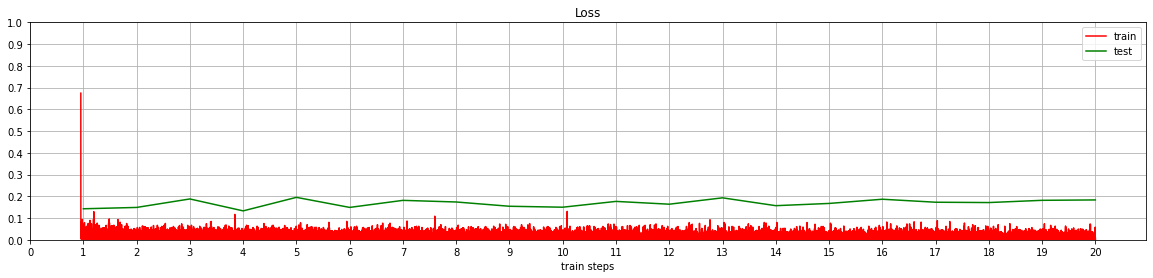

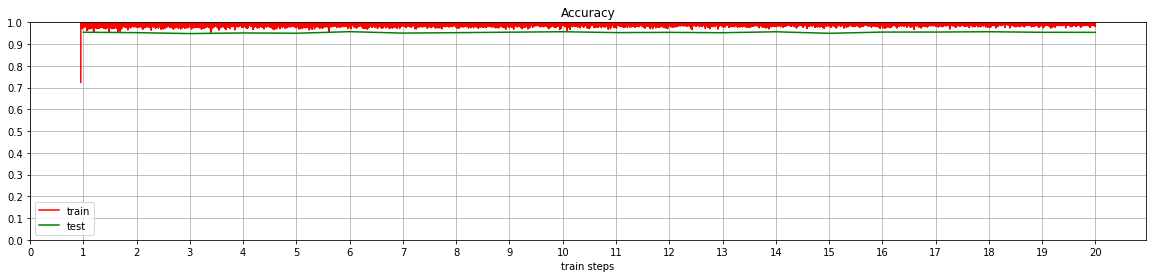

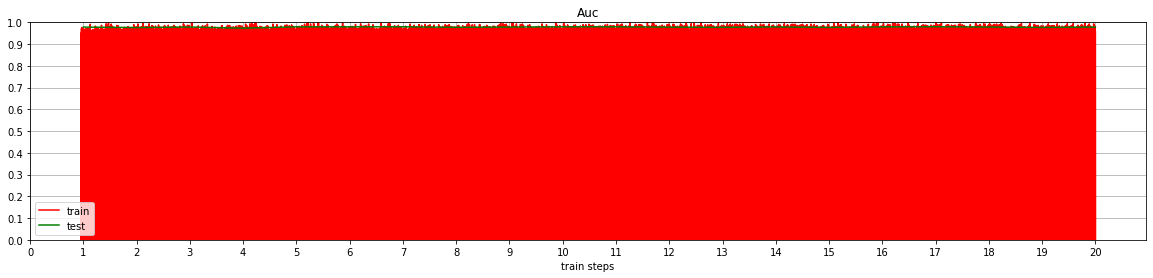

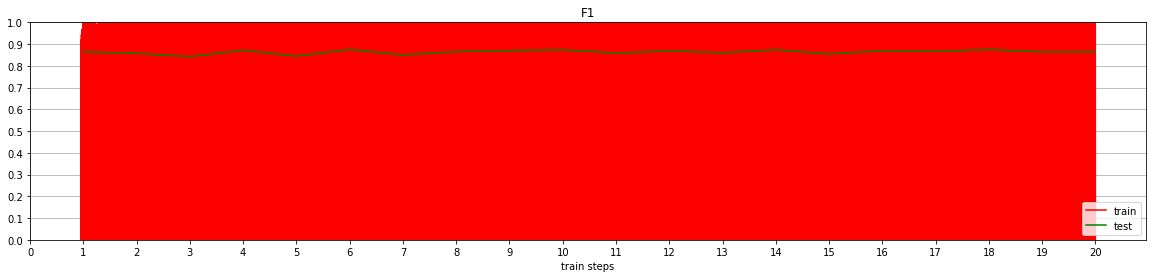

Time:  29089683.639432687
Epoch 20: ROC-AUC = 97.84%
Epoch 20: Precision = 0.921
Epoch 20: Recall = 0.817
Epoch 20: F1-score = 0.865
Final ROC-AUC = 97.84%
Final Precision = 0.921
Final Recall = 0.817
Final F1-score = 0.865


In [43]:
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(model, opt, 20)

In [44]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 5
Max F1-score: 87.5293%
ROC-AUC: 97.9378%
Precision: 0.9170
Recall: 0.8393
Mean time for 1 epoch 13.30 minutes


In [45]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), './models/zdna.pt')

# Scale omics by overall max value

In [46]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]

feature_names = [i[:-4] for i in os.listdir('./data_hg_38/features/sparse_max_scaled/stem_cells') if i.endswith('.pkl')]

In [47]:
DNA_features = {feature: load(f'./data_hg_38/features/sparse_max_scaled/stem_cells/{feature}.pkl')
                for feature in tqdm(feature_names)}

  0%|          | 0/322 [00:00<?, ?it/s]

In [48]:
loader_train, loader_test = get_train_test_data(max_omics_value=5382)

100%|██████████| 572274/572274 [00:06<00:00, 92724.57it/s] 


In [49]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_12_layers()
    model = nn.DataParallel(model)
    model = model.to(device)
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

gc.collect()

0

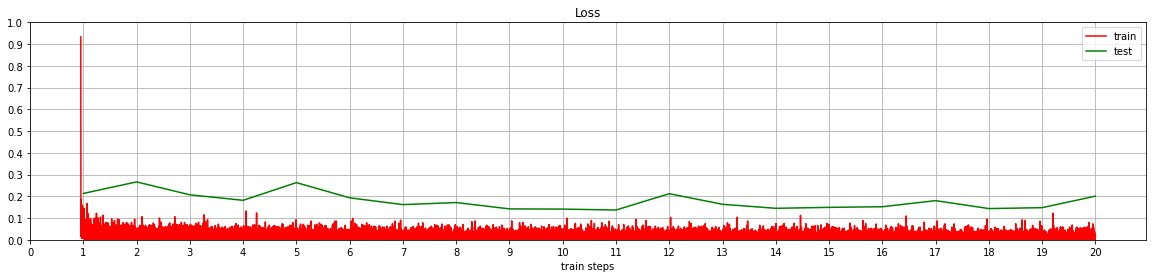

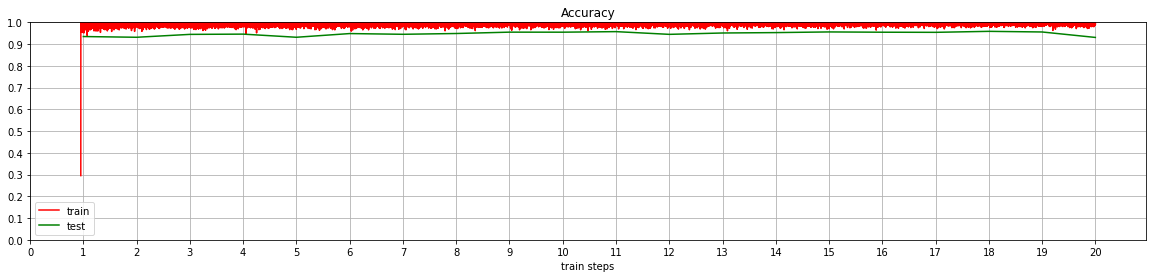

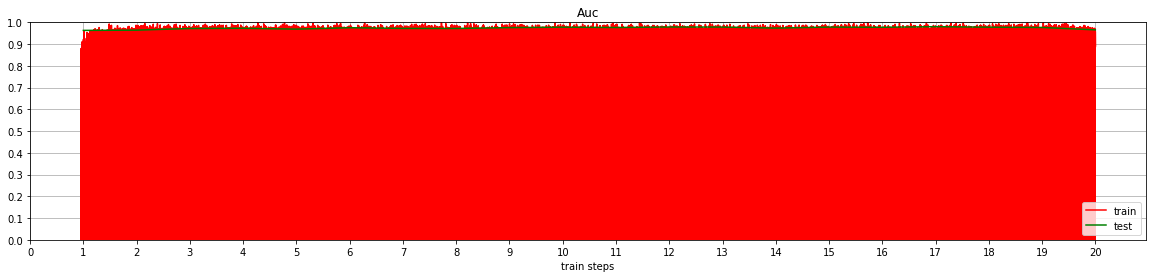

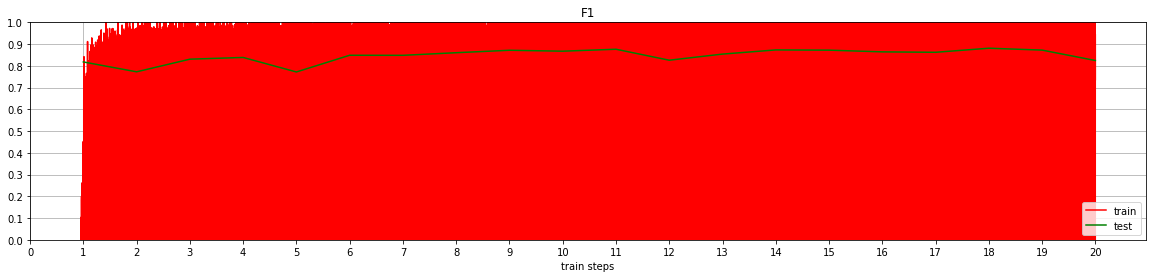

Time:  29089963.025248982
Epoch 20: ROC-AUC = 96.55%
Epoch 20: Precision = 0.759
Epoch 20: Recall = 0.906
Epoch 20: F1-score = 0.825
Final ROC-AUC = 96.55%
Final Precision = 0.759
Final Recall = 0.906
Final F1-score = 0.825


In [50]:
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(model, opt, 20)

In [51]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 17
Max F1-score: 88.1057%
ROC-AUC: 97.7852%
Precision: 0.9135
Recall: 0.8527
Mean time for 1 epoch 13.59 minutes


In [52]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), './models/zdna_max_scaled_omicses.pt')

# Binarizing omics

In [34]:
loader_train, loader_test = get_train_test_data(max_omics_value=1)

100%|██████████| 572274/572274 [00:06<00:00, 93462.44it/s] 


In [35]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_12_layers()
    model = nn.DataParallel(model)
    model = model.to(device)
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

gc.collect()

51

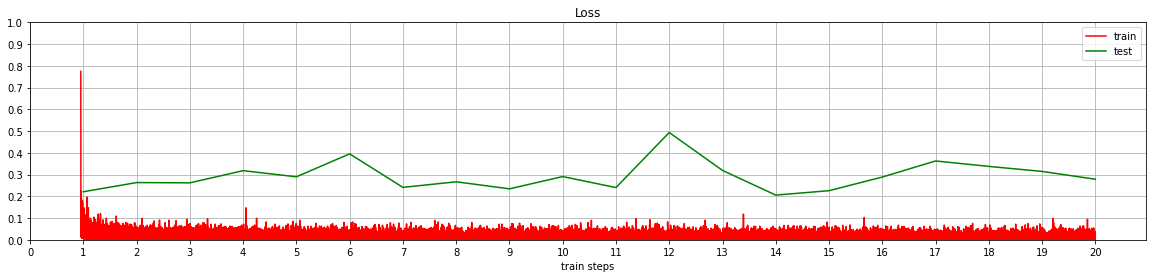

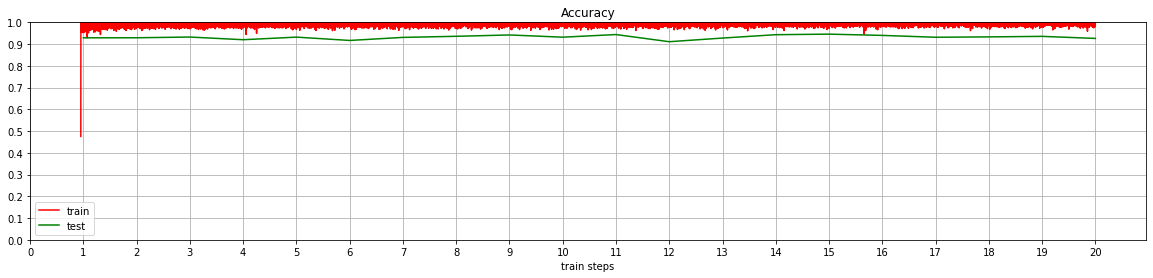

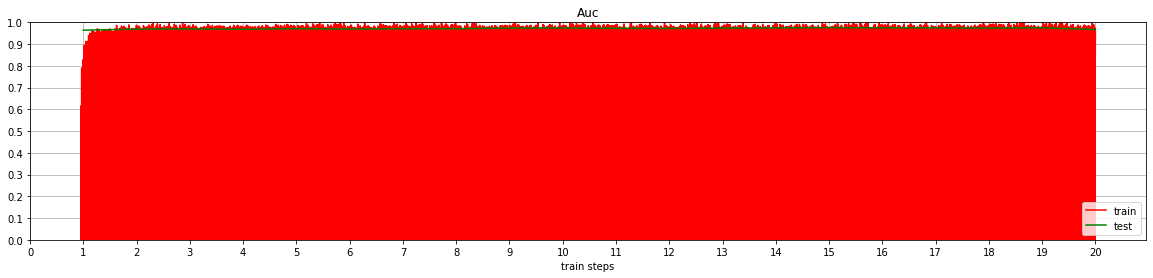

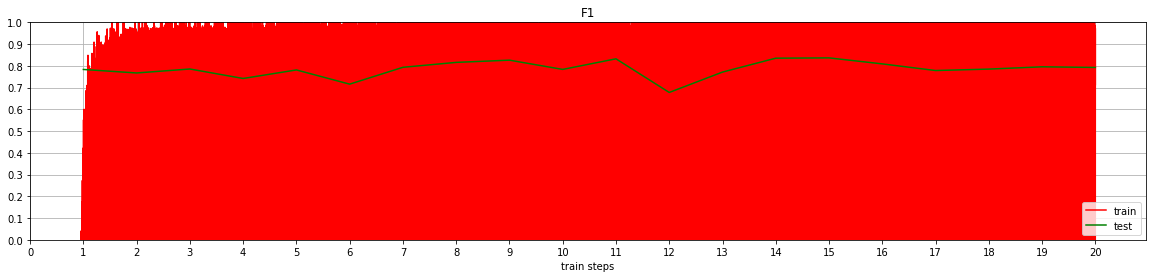

Time:  29089410.074771386
Epoch 20: ROC-AUC = 96.71%
Epoch 20: Precision = 0.8
Epoch 20: Recall = 0.79
Epoch 20: F1-score = 0.793
Final ROC-AUC = 96.71%
Final Precision = 0.8
Final Recall = 0.79
Final F1-score = 0.793


In [36]:
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(model, opt, 20)

In [37]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 14
Max F1-score: 83.6629%
ROC-AUC: 97.6033%
Precision: 0.9110
Recall: 0.7763
Mean time for 1 epoch 13.47 minutes


In [ ]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), './models/zdna_binary_omicses.pt')

# Scale each omics dividing by its max value

In [30]:
feature_max_values = {}

for feature in feature_names:
    feature_data = DNA_features[feature]
    max_val = 0
    for chrom in chrom_names:
        if chrom in feature_data:
            max_val = feature_data[chrom].data.max()
    feature_max_values[feature] = max_val if max_val > 0 else 1.0

In [31]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, max_omics_value=1000):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            max_val = feature_max_values.get(feature, 1.0)
            if chrom in source:
                feature_data = source[chrom][begin:end] / max_val
                feature_matr.append(feature_data)
            else:
                feature_matr.append(np.zeros(end - begin, dtype=np.float32))

        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)

        y = self.labels_source[interval[0]][interval[1]: interval[2]]
        return (X, y)

In [32]:
width = 100
loader_train, loader_test = get_train_test_data()

100%|██████████| 572274/572274 [00:06<00:00, 92597.79it/s]


In [33]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_12_layers()
    model = nn.DataParallel(model)
    model = model.to(device)
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

gc.collect()

53

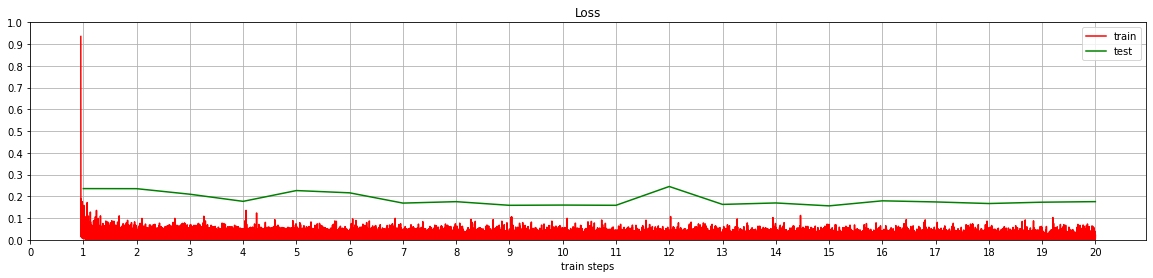

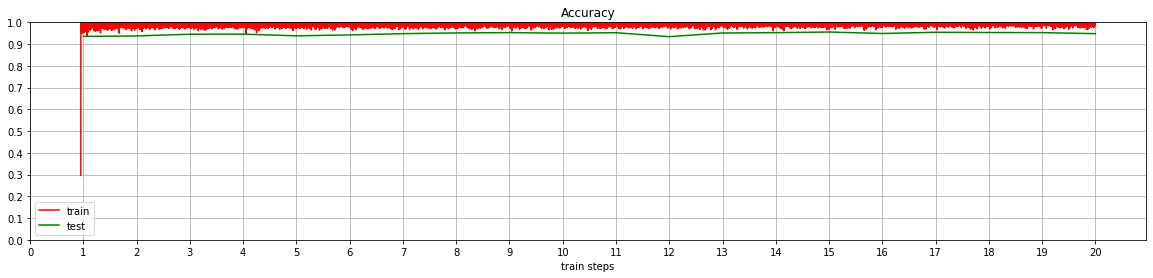

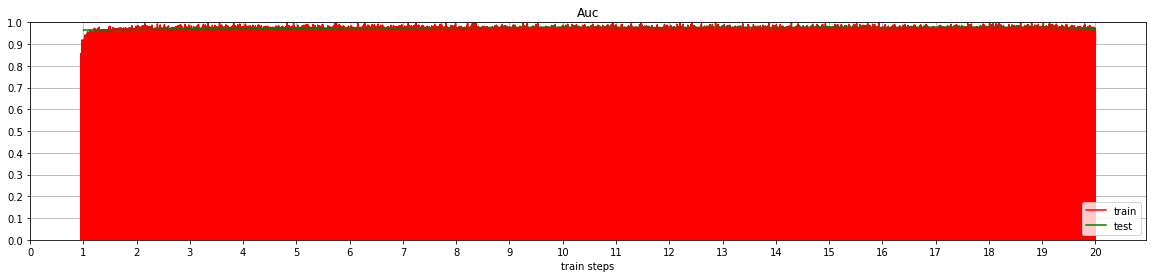

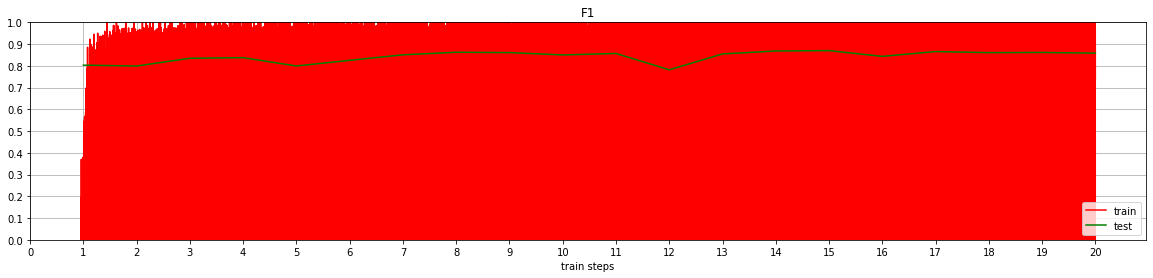

Time:  29092126.207214735
Epoch 20: ROC-AUC = 97.23%
Epoch 20: Precision = 0.842
Epoch 20: Recall = 0.878
Epoch 20: F1-score = 0.858
Final ROC-AUC = 97.23%
Final Precision = 0.842
Final Recall = 0.878
Final F1-score = 0.858


In [34]:
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(model, opt, 20)

In [35]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 14
Max F1-score: 87.0110%
ROC-AUC: 97.8949%
Precision: 0.9146
Recall: 0.8319
Mean time for 1 epoch 13.55 minutes


In [36]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), './models/zdna_omicses_scaled_by_feature_max.pt')

# Scale each omics by mean and variance

In [23]:
feature_mean_var = {}
total_len = sum(len(chrom_reader(chrom)) for chrom in chrom_names)

for feature in feature_names:
    feature_data = DNA_features[feature]
    
    total_sum = 0.0
    total_sq_sum = 0.0

    for vec in feature_data.values():
        values = vec.data
        indices = vec.indices
        shape = vec.shape

        segment_lengths = np.empty_like(values)
        segment_lengths[:-1] = indices[1:] - indices[:-1]
        segment_lengths[-1] = shape - indices[-1]

        total_sum += np.sum(values * segment_lengths)
        total_sq_sum += np.sum((values ** 2) * segment_lengths)

    mean = total_sum / total_len
    var = total_sq_sum / total_len - mean ** 2
    std = np.sqrt(var) if var > 1e-8 else 1.0
    
    feature_mean_var[feature] = [mean, std]

In [24]:
class Dataset(data.Dataset):
    def __init__(self, chroms, features,
                 dna_source, features_source,
                 labels_source, intervals, max_omics_value=1000):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels_source = labels_source
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, index):
        interval = self.intervals[index]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))

        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            mean = feature_mean_var.get(feature)[0]
            var = feature_mean_var.get(feature)[1]
            if chrom in source:
                feature_data = (source[chrom][begin:end] - mean) / var
            else:
                feature_data = (np.zeros(end - begin, dtype=np.float32) - mean) / var
            feature_matr.append(feature_data)

        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)

        y = self.labels_source[interval[0]][interval[1]: interval[2]]

        return (X, y)

In [25]:
width = 100
loader_train, loader_test = get_train_test_data()

100%|██████████| 572274/572274 [00:06<00:00, 94414.51it/s]


In [26]:
set_random_seed(42)
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.cuda.device(device):
    model = DeepCNN_12_layers()
    model = nn.DataParallel(model)
    model = model.to(device)
opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

gc.collect()

51

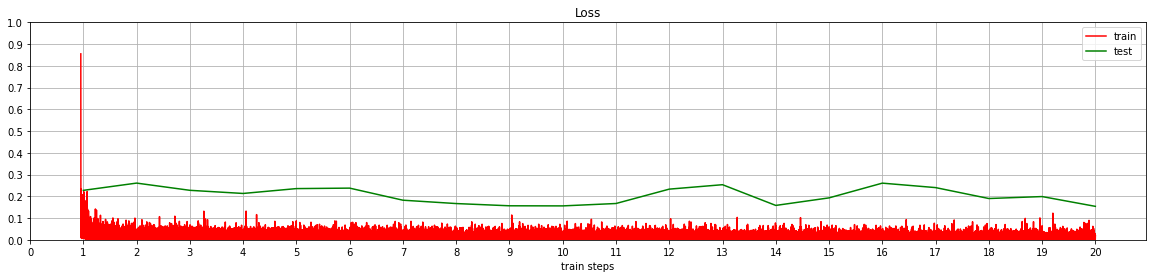

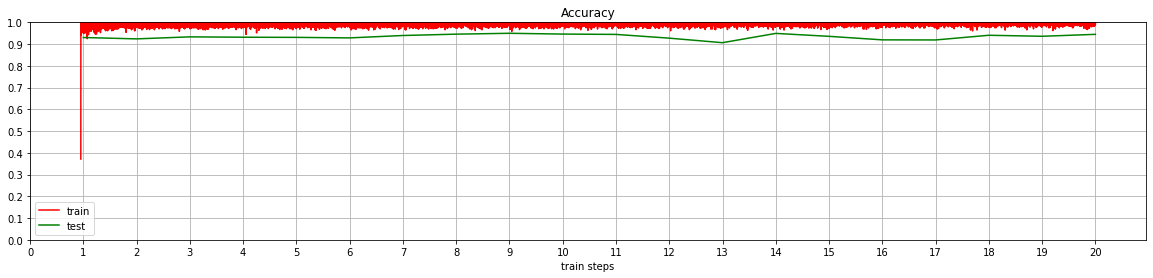

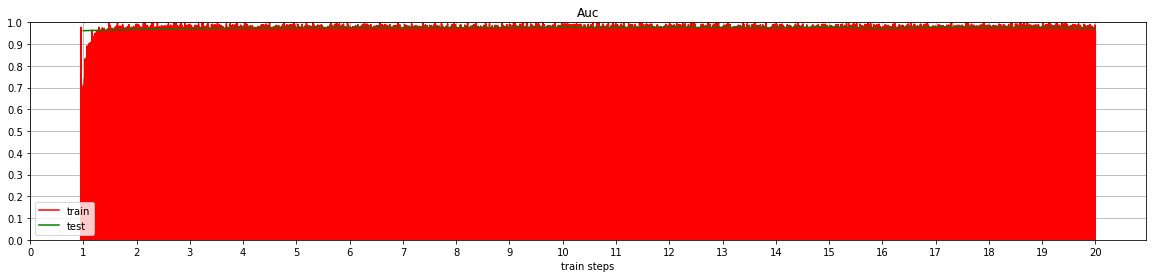

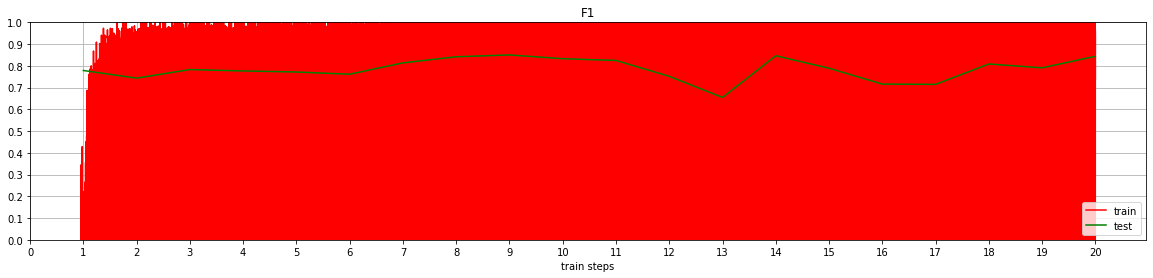

Time:  29091847.88089679
Epoch 20: ROC-AUC = 97.22%
Epoch 20: Precision = 0.859
Epoch 20: Recall = 0.832
Epoch 20: F1-score = 0.844
Final ROC-AUC = 97.22%
Final Precision = 0.859
Final Recall = 0.832
Final F1-score = 0.844


In [27]:
val_auc_log, val_pr_log, val_rec_log, val_f1_log, val_acc_log, val_loss_log, times, best_models = train(model, opt, 20)

In [28]:
print("Epoch {}".format(np.argmax(val_f1_log)))
print("Max F1-score: {:.4f}%".format(val_f1_log[np.argmax(val_f1_log)]*100))
print("ROC-AUC: {:.4f}%".format(val_auc_log[np.argmax(val_f1_log)]*100))
print("Precision: {:.4f}".format(val_pr_log[np.argmax(val_f1_log)]))
print("Recall: {:.4f}".format(val_rec_log[np.argmax(val_f1_log)]))

print("Mean time for 1 epoch {:.2f} minutes".format(np.mean(times) / 60))

Epoch 8
Max F1-score: 85.0097%
ROC-AUC: 97.5632%
Precision: 0.9168
Recall: 0.7947
Mean time for 1 epoch 13.39 minutes


In [29]:
torch.save(best_models[np.argmax(val_f1_log)].state_dict(), './models/zdna_omicses_scaled_by_feature_mean_var.pt')